# Example how to use my implementation of the Per Sample IBA
Note: This code uses cuda  
Note: You have to download the image data manually

In [1]:
%matplotlib inline
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

In [2]:
import random
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import PIL
import torch
import torchvision

from fish_models.models.pascals_lstms.iba import PerSampleIBA

## Load pretrained VGG16 Image Classification Model

In [3]:
model_path = Path("../../data/models/vgg16.pt")

In [4]:
if model_path.exists():
    vgg16 = torchvision.models.vgg16(pretrained=False)
    vgg16.load_state_dict(torch.load(model_path))
    print("loaded saved state dict")
else:
    vgg16 = torchvision.models.vgg16(pretrained=True)
    torch.save(vgg16.state_dict(), model_path)
    print("loaded model. saved state dict")

loaded saved state dict


In [5]:
_ = vgg16.to("cuda")

In [6]:
next(vgg16.parameters()).device

device(type='cuda', index=0)

## Load Imagenet Dataset
Or rather a small subset. I took this https://www.kaggle.com/ifigotin/imagenetmini-1000 . You have to manually put this data into "../../data/raw/imagenet-mini/"

In [7]:
class ImageNet(torch.utils.data.Dataset):
    def __init__(self, root_dir, train=False):

            self.root_dir = root_dir
            
            def unsqueeze_tensor(pic):
                if pic.shape[0]==1:
                    return pic.repeat(3,1,1)
                else:
                    return pic
                
            
            self.transform = torchvision.transforms.Compose([
                torchvision.transforms.Resize((224,224)),
                torchvision.transforms.ToTensor(),
                unsqueeze_tensor,
                torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                ])

            self.sub_directory = 'train' if train else 'val'
                        
            self.imgs = list((root_dir / self.sub_directory).glob("*/[!.]*"))
            
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self,idx):
        with PIL.Image.open(self.imgs[idx]) as im:
            img = self.transform(im);
        # Return shape is (3, X, Y)
        return img;

In [8]:
data_path = Path("../../data/raw/imagenet-mini/")
val_path = data_path / "val"
N = 32

In [9]:
#some imgs are black&white, unsqueeze_tensor converts them to have 3 color channels
def unsqueeze_tensor(pic): 
    if pic.shape[0]==1:
        return pic.repeat(3,1,1)
    else:
        return pic

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.ToTensor(),
    unsqueeze_tensor,
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

imagenet_data = torchvision.datasets.ImageFolder(val_path, transform=transform)
data_loader = torch.utils.data.DataLoader(
    imagenet_data,
    batch_size=N,
    shuffle=False,
    num_workers=0
)


## Create a PerSampleIBA after one of the conv layers
Note: Be careful not to put it directly after a ReLU, because the IBA Method will produce negative values (which should be impossible after a ReLU)

In [10]:
vgg16.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [11]:
convLayer = vgg16.features[14]

### During `__init__`, the mean and stdev of each feature will be estimated

In [12]:
iba = PerSampleIBA(vgg16, convLayer, data_loader, recurrent_flag=False, device="cuda")

100%|██████████| 123/123 [00:27<00:00,  4.43it/s]


In [13]:
iba.layer_output_shape

torch.Size([256, 56, 56])

### Looking at the infos calculated during the `__init__ `

In [14]:
# % of neurons that are active in the feature maps
iba.active_neurons_R.detach().cpu().numpy().astype(int).sum(axis=None) / np.prod(iba.active_neurons_R.shape)

1.0

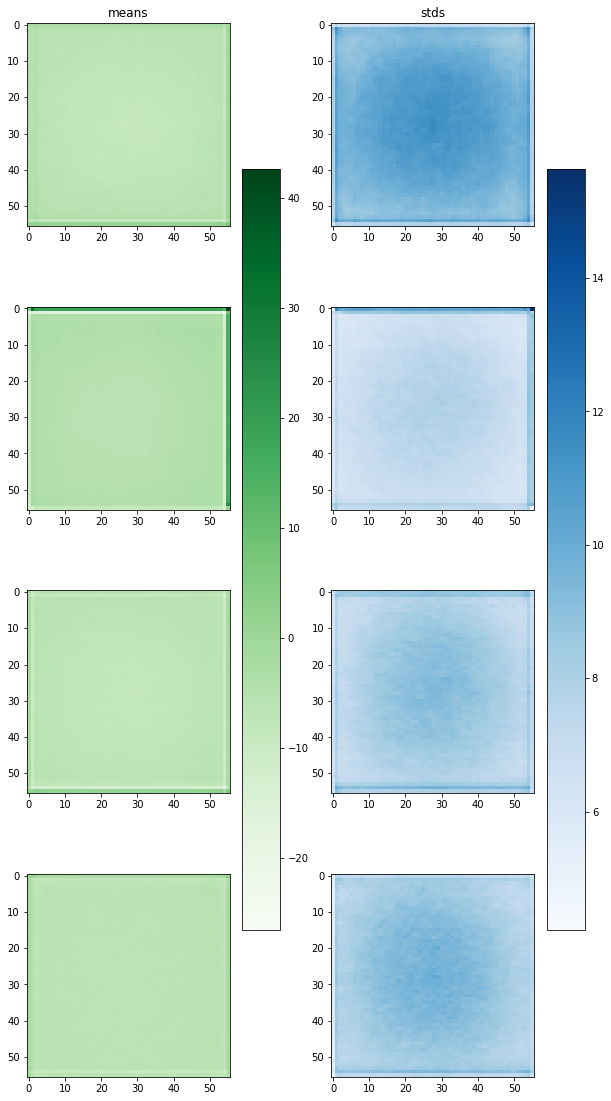

In [15]:
# Mean and stdev of the features in the channels 4,19, 31 and 72 (arbitrarily chosen numbers) of the conv layer we are looking at
fig, axes = plt.subplots(nrows=4,ncols=2, figsize=(10,20))

channels = [4,19,31,72]

means = iba.mean_R.detach().cpu().numpy()[channels]
stds = iba.std_R.detach().cpu().numpy()[channels]

mean_imgs, std_imgs = [], []
for i, (mean, std) in enumerate(zip(means, stds)):
    mean_imgs.append(axes[i,0].imshow(mean, cmap="Greens"))
    std_imgs.append(axes[i,1].imshow(std, cmap="Blues"))
    
norm_means = colors.Normalize(vmin=means.min(),vmax=means.max())
norm_stds = colors.Normalize(vmin=stds.min(),vmax=stds.max())
for m, s in zip(mean_imgs, std_imgs):
    m.set_norm(norm_means)
    s.set_norm(norm_stds)

axes[0,0].set_title(label='means')
axes[0,1].set_title(label='stds')
    
fig.colorbar(mean_imgs[0], ax=axes[:,0], orientation='vertical')
fig.colorbar(std_imgs[0], ax=axes[:,1], orientation='vertical')


## Pick an Image and use the PerSampleIBA to calculate an attribution heatmap for each feature

In [16]:
image, label = imagenet_data[41]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 11


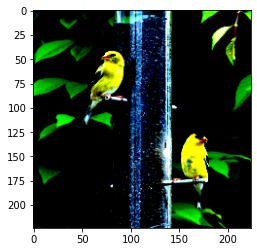

In [17]:
# This image seems weird because the imagenet transforms (cropping and especially normalizing) have already been performed
print(f"label: {label}")
plt.imshow(torch.moveaxis(image, source=0, destination=2))

## Regular per sample IBA
with CrossEntropy Loss as the model loss (which is what the vgg16 was trained with)  
`target=label` is the setting for this

 10%|█         | 1/10 [00:00<00:00,  9.46it/s]

seed: 3209311580936336789
Model and Info Loss: 0.0006351 | 4.6744118
Predicted classes tensor([11, 11, 11, 11, 11, 11, 11, 11, 11, 11])


 20%|██        | 2/10 [00:00<00:01,  5.37it/s]

Model and Info Loss: 0.0006897 | 3.7974486
Predicted classes tensor([11, 11, 11, 11, 11, 11, 11, 11, 11, 11])


 30%|███       | 3/10 [00:00<00:01,  4.54it/s]

Model and Info Loss: 0.0007961 | 2.9038811
Predicted classes tensor([11, 11, 11, 11, 11, 11, 11, 11, 11, 11])


 40%|████      | 4/10 [00:00<00:01,  4.24it/s]

Model and Info Loss: 0.0011346 | 1.9957699
Predicted classes tensor([11, 11, 11, 11, 11, 11, 11, 11, 11, 11])


 50%|█████     | 5/10 [00:01<00:01,  4.08it/s]

Model and Info Loss: 0.002135 | 1.127108
Predicted classes tensor([11, 11, 11, 11, 11, 11, 11, 11, 11, 11])


 60%|██████    | 6/10 [00:01<00:01,  3.99it/s]

Model and Info Loss: 0.0084248 | 0.4605569
Predicted classes tensor([11, 11, 11, 11, 11, 11, 11, 11, 11, 11])


 70%|███████   | 7/10 [00:01<00:00,  3.94it/s]

Model and Info Loss: 2.7305794 | 0.1318044
Predicted classes tensor([ 11, 794,  11, 794, 794,  11,  11, 794, 794,  11])


 80%|████████  | 8/10 [00:01<00:00,  3.90it/s]

Model and Info Loss: 0.0030862 | 0.0841607
Predicted classes tensor([11, 11, 11, 11, 11, 11, 11, 11, 11, 11])


 90%|█████████ | 9/10 [00:02<00:00,  3.87it/s]

Model and Info Loss: 0.0014266 | 0.0798599
Predicted classes tensor([11, 11, 11, 11, 11, 11, 11, 11, 11, 11])


100%|██████████| 10/10 [00:02<00:00,  4.10it/s]

Model and Info Loss: 0.0004054 | 0.0888995
Predicted classes tensor([11, 11, 11, 11, 11, 11, 11, 11, 11, 11])


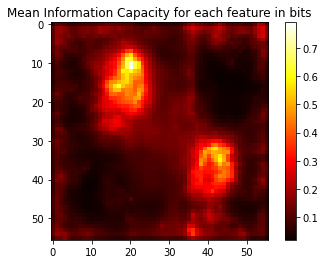

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


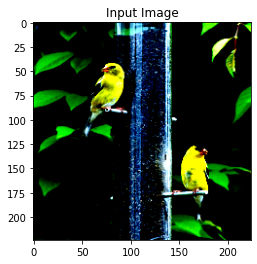

In [20]:
#torch.manual_seed(0)
print(f"seed: {torch.seed()}")

capacity = iba.attribute(
    inputs=image.unsqueeze(0),
    target=label,
    optimization_steps=10,
    batch_size=10,
    beta=10,
    lr=1.0,
    sigma=1.0,
    initial_alpha=5.0,
    verbose=True,
)

#plt.figure(figsize=(10, 10))
plt.imshow(capacity.mean(axis=0), cmap="hot")
plt.colorbar()
plt.title("Mean Information Capacity for each feature in bits")
plt.show()
plt.imshow(torch.moveaxis(image, source=0, destination=2))
plt.title("Input Image")
plt.show()

## Variant sample IBA
with KL-Divergence between original output and actual output as the model loss  
`target=None` is the setting for this

  0%|          | 0/10 [00:00<?, ?it/s]

seed: 12600852072022149860
Model and Info Loss: 4.2e-06 | 4.6744118
Predicted classes tensor([11, 11, 11, 11, 11, 11, 11, 11, 11, 11])


 20%|██        | 2/10 [00:00<00:01,  5.57it/s]

Model and Info Loss: 1.37e-05 | 3.7974486
Predicted classes tensor([11, 11, 11, 11, 11, 11, 11, 11, 11, 11])


 30%|███       | 3/10 [00:00<00:01,  4.68it/s]

Model and Info Loss: 4.74e-05 | 2.9038808
Predicted classes tensor([11, 11, 11, 11, 11, 11, 11, 11, 11, 11])


 40%|████      | 4/10 [00:00<00:01,  4.32it/s]

Model and Info Loss: 0.0002456 | 1.9957689
Predicted classes tensor([11, 11, 11, 11, 11, 11, 11, 11, 11, 11])


 50%|█████     | 5/10 [00:01<00:01,  4.14it/s]

Model and Info Loss: 0.0008884 | 1.1271031
Predicted classes tensor([11, 11, 11, 11, 11, 11, 11, 11, 11, 11])


 60%|██████    | 6/10 [00:01<00:00,  4.04it/s]

Model and Info Loss: 0.0047558 | 0.460529
Predicted classes tensor([11, 11, 11, 11, 11, 11, 11, 11, 11, 11])


 70%|███████   | 7/10 [00:01<00:00,  3.97it/s]

Model and Info Loss: 4.3883185 | 0.1315115
Predicted classes tensor([728, 794, 794, 794, 794, 794,  11, 669,  11, 794])


 80%|████████  | 8/10 [00:01<00:00,  3.93it/s]

Model and Info Loss: 0.0057185 | 0.0876876
Predicted classes tensor([11, 11, 11, 11, 11, 11, 11, 11, 11, 11])


 90%|█████████ | 9/10 [00:02<00:00,  3.90it/s]

Model and Info Loss: 0.002061 | 0.0856482
Predicted classes tensor([11, 11, 11, 11, 11, 11, 11, 11, 11, 11])


100%|██████████| 10/10 [00:02<00:00,  4.09it/s]

Model and Info Loss: 0.0009213 | 0.0968141
Predicted classes tensor([11, 11, 11, 11, 11, 11, 11, 11, 11, 11])


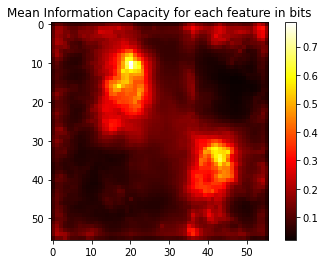

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


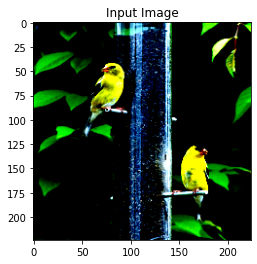

In [21]:
#torch.manual_seed(0)
print(f"seed: {torch.seed()}")

capacity = iba.attribute(
    inputs=image.unsqueeze(0),
    target=None,
    optimization_steps=10,
    batch_size=10,
    beta=10,
    lr=1.0,
    sigma=1.0,
    initial_alpha=5.0,
    verbose=True,
)

#plt.figure(figsize=(10, 10))
plt.imshow(capacity.mean(axis=0), cmap="hot")
plt.colorbar()
plt.title("Mean Information Capacity for each feature in bits")
plt.show()
plt.imshow(torch.moveaxis(image, source=0, destination=2))
plt.title("Input Image")
plt.show()